In [57]:
import os
import SimpleITK as sitk
import copy
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from segment_anything import sam_model_registry
from skimage import transform
import cv2
from ipywidgets import interact, widgets
from tqdm import tqdm

# Model

In [124]:
MedSAM_CKPT_PATH = "../rpa-dataset/MedSAM/evaluation/MedSAM-ViT-B-20250307-2222/medsam_model_best_converted.pth"
device = "cpu"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


# Dataset

In [125]:
path_to_aires_ganglionnaires = '/Users/fcremone/dev/research/ontology-olivier/aires-ganglionnaires/Dicom_RT_and_Images_to_Mask/Examples/nifti/'
file_list = os.listdir(path_to_aires_ganglionnaires)

In [126]:
data_list = [x for x in file_list if 'Data' in x]
mask_list = [x for x in file_list if 'mask' in x]

In [127]:
def datafilename2maskfilename(fname):
    maskname = copy.copy(fname)
    maskname = maskname.replace('Data', 'mask')
    pat_id = fname.split('_')[-1].split('.')[0]
    maskname = '_'.join(maskname.split('_')[:-1])
    maskname += f'_y{pat_id}.nii.gz'
    return maskname

In [128]:
datafilename2maskfilename(data_list[0])

'Overall_mask_Examples_y9.nii.gz'

In [129]:
class RpaDataset(Dataset):
    def __init__(self, root_path, data_list, window, level):
        self.root_path = root_path
        self.data_list = data_list
        self.l = level
        self.w = window

    def __getitem__(self, index):
        filename = os.path.join(self.root_path, self.data_list[index])
        img = sitk.ReadImage(filename)
        img = torch.permute(torch.tensor(sitk.GetArrayFromImage(img)), (1,2,0))
        img = torch.clip((img - self.l + 0.5*self.w)/self.w, 0, 1)
        filename = os.path.join(self.root_path, datafilename2maskfilename(self.data_list[index]))
        mask = sitk.ReadImage(filename)
        mask = torch.permute(torch.tensor(sitk.GetArrayFromImage(mask)), (1,2,0))
        return img, mask

    def __len__(self):
        return len(self.data_list)

In [130]:
rpadata = RpaDataset(path_to_aires_ganglionnaires, data_list, window=350, level=40)

In [131]:
img, mask = rpadata[0]
print(f'{rpadata.data_list[0]}')

Overall_Data_Examples_9.nii.gz


In [132]:
img.shape, img.max(), img.min()

(torch.Size([512, 512, 164]), tensor(1.), tensor(0.))

In [133]:
num2levelname = {
     1: 'level_ia_left',
     2: 'level_ia_right',
     3: 'level_ib_left',
     4: 'level_ib_right',
     5: 'level_ii_left',
     6: 'level_ii_right',
     7: 'level_iii_left',
     8: 'level_iii_right',
     9: 'level_iv_left',
    10: 'level_iv_right',
    11: 'level_v_left',
    12: 'level_v_right',
    13: 'level_rp_left',
    14: 'level_rp_right',
}
levelname2num = {val: key for key, val in num2levelname.items()}

In [134]:
slice_ = 71
level = 'level_ii_left'
levelnum = levelname2num[level]
binmask = (mask[:,:,slice_] == levelnum).to(torch.uint8)

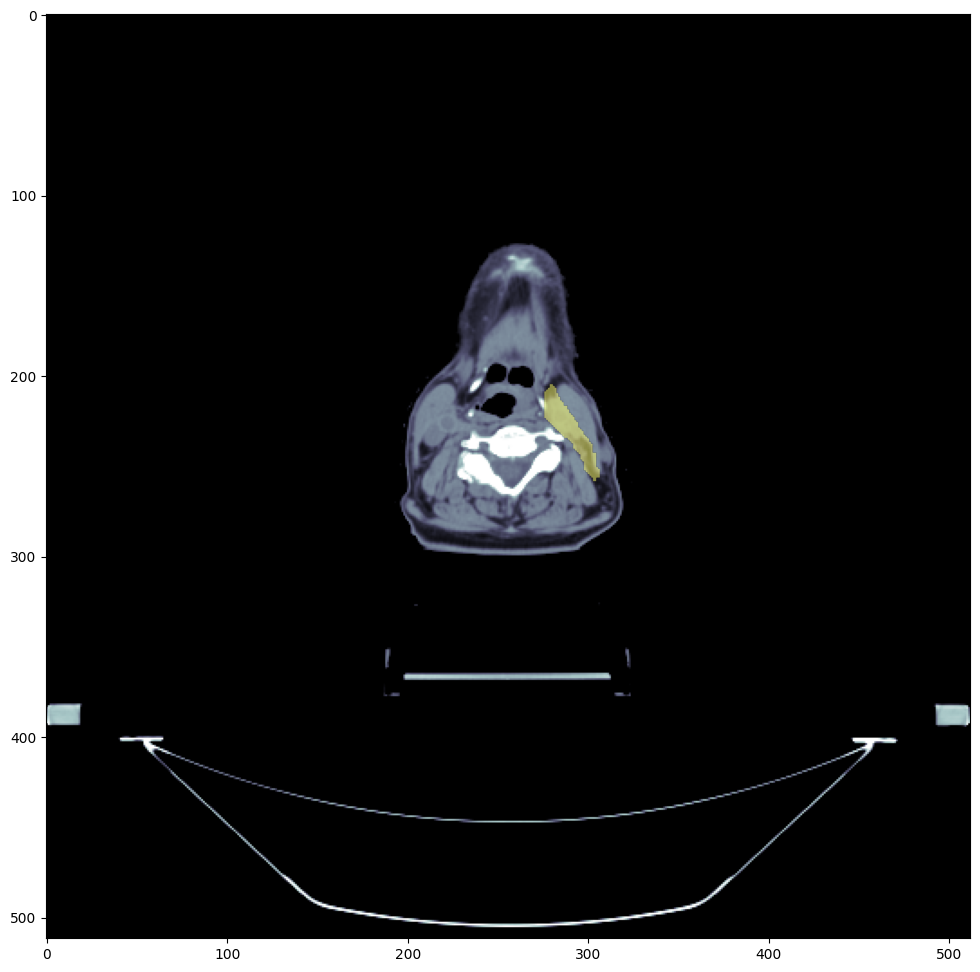

In [135]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(img[..., slice_], cmap='bone')
ax.imshow(np.ma.masked_where(binmask < 0.5, binmask), cmap='summer', vmin=0., vmax=1, alpha=0.5)

# Inference on trained model

In [86]:
W, H = img.shape[0], img.shape[1]
img_3c = np.stack(3*[img[...,slice_]], axis=-1).squeeze()

### Point prompts

In [16]:
class PointPromptDemo:
    def __init__(self, model):
        self.model = model
        self.model.eval()
        self.image = None
        self.image_embeddings = None
        self.img_size = None


    def show_mask(self, mask, ax, random_color=False, alpha=0.95):
        if random_color:
            color = np.concatenate([np.random.random(3), np.array([alpha])], axis=0)
        else:
            color = np.array([251/255, 252/255, 30/255, alpha])
        h, w = mask.shape[-2:]
        mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
        ax.imshow(mask_image)

    @torch.no_grad()
    def infer(self, x, y):
        coords_1024 = np.array([[[
            x * 1024 / self.img_size[1],
            y * 1024 / self.img_size[0]
        ]]])
        coords_torch = torch.tensor(coords_1024, dtype=torch.float32).to(self.model.device)
        labels_torch = torch.tensor([[1]], dtype=torch.long).to(self.model.device)
        point_prompt = (coords_torch, labels_torch)

        sparse_embeddings, dense_embeddings = self.model.prompt_encoder(
            points = point_prompt,
            boxes = None,
            masks = None,
        )
        low_res_logits, _ = self.model.mask_decoder(
            image_embeddings=self.image_embeddings, # (B, 256, 64, 64)
            image_pe=self.model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
            sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
            dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
            multimask_output=False,
        )

        low_res_probs = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)
        low_res_pred = F.interpolate(
            low_res_probs,
            size = self.img_size,
            mode = 'bilinear',
            align_corners = False
        )
        low_res_pred = low_res_pred.detach().cpu().numpy().squeeze()

        seg = np.uint8(low_res_pred > 0.5)

        return seg

    def show(self, fig_size=5, alpha=0.95, scatter_size=10):

        assert self.image is not None, "Please set image first."
        seg = None
        fig, ax = plt.subplots(1, 1, figsize=(fig_size, fig_size))
        fig.canvas.header_visible = False
        fig.canvas.footer_visible = False
        fig.canvas.toolbar_visible = False
        fig.canvas.resizable = False

        plt.tight_layout()

        ax.imshow(self.image)
        ax.axis('off')

        def onclick(event):
            if event.inaxes == ax:
                x, y = float(event.xdata), float(event.ydata)
                with torch.no_grad():
                    ## rescale x, y from canvas size to 1024 x 1024
                    seg = self.infer(x, y)

                ax.clear()
                ax.imshow(self.image)
                ax.axis('off')
                ax.scatter(x, y, c='r', s=scatter_size)
                self.show_mask(seg, ax, random_color=False, alpha=alpha)

                gc.collect()

        fig.canvas.mpl_connect('button_press_event', onclick)
        plt.show()

        save_button = widgets.Button(description="save")
        def __on_save_button_clicked(b):
            plt.savefig("seg_result.png", bbox_inches='tight', pad_inches=0)
            if seg is not None:
                cv2.imwrite("seg.png", seg)
                print(f"Segmentation result saved to {getcwd()}")

        display(save_button)
        save_button.on_click(__on_save_button_clicked)

    def set_image(self, image):
        self.img_size = image.shape[:2]
        if len(image.shape) == 2:
            image = np.repeat(image[:,:,None], 3, -1)
        self.image = image
        image_preprocess = self.preprocess_image(self.image)
        with torch.no_grad():
            self.image_embeddings = self.model.image_encoder(image_preprocess)

    def preprocess_image(self, image):
        img_resize = cv2.resize(
            image,
            (1024, 1024),
            interpolation=cv2.INTER_CUBIC
        )
        # Resizing
        img_resize = (img_resize - img_resize.min()) / np.clip(img_resize.max() - img_resize.min(), a_min=1e-8, a_max=None) # normalize to [0, 1], (H, W, 3
        # convert the shape to (3, H, W)
        assert np.max(img_resize)<=1.0 and np.min(img_resize)>=0.0, 'image should be normalized to [0, 1]'
        img_tensor = torch.tensor(img_resize).float().permute(2, 0, 1).unsqueeze(0).to(self.model.device)

        return img_tensor


In [17]:
points_medsam_demo = PointPromptDemo(medsam_model)

In [18]:
points_medsam_demo.set_image(img_3c)

In [19]:
w = np.where(binmask > 0)
prompt_index_selectors = np.random.choice(list(range(len(w[0]))), size=(5))
prompt_x = w[0][prompt_index_selectors]
prompt_y = w[1][prompt_index_selectors]

In [20]:
seg = points_medsam_demo.infer(prompt_x[0], prompt_y[0])

In [21]:
print(seg.shape, seg.min(), seg.max())

(512, 512) 0 0


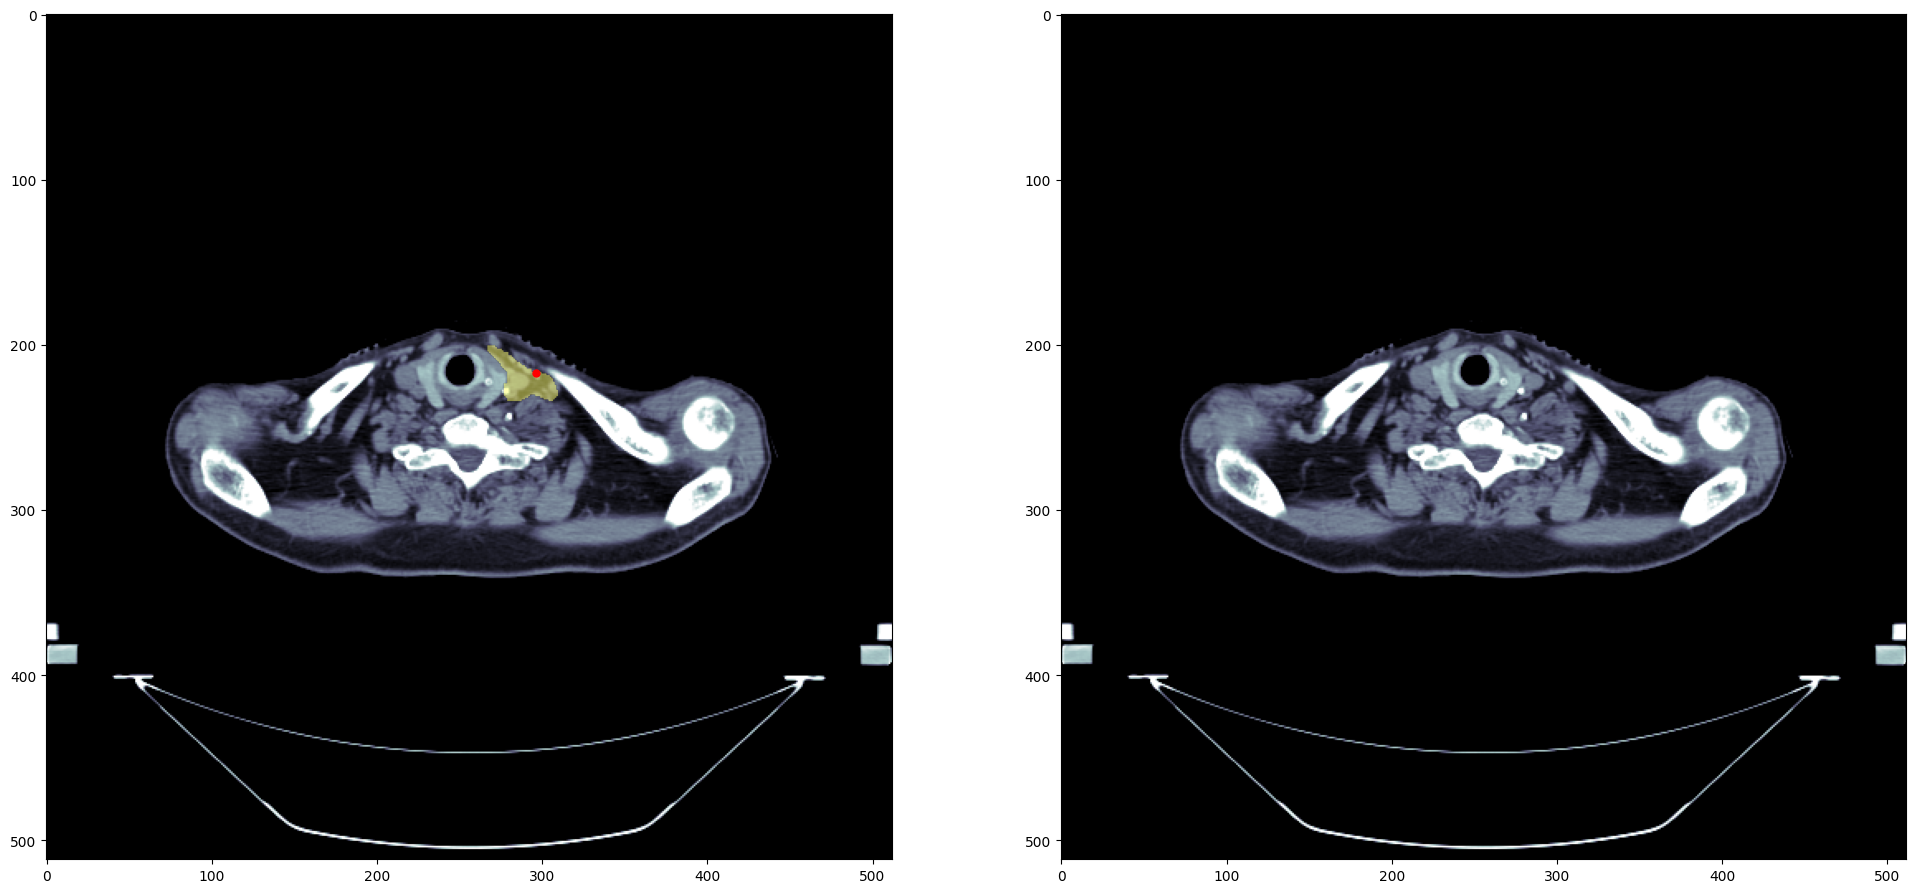

In [22]:
fig, ax = plt.subplots(1,2,figsize=(24,12))
ax[0].imshow(img[..., slice_], cmap='bone')
ax[0].imshow(np.ma.masked_where(binmask < 0.5, binmask), cmap='summer', vmin=0., vmax=1, alpha=0.5)
ax[0].plot(prompt_y[0], prompt_x[0], 'o', color='red', markersize=5)
ax[1].imshow(img[..., slice_], cmap='bone')
ax[1].imshow(np.ma.masked_where(seg < 0.5, seg), cmap='summer', vmin=0., vmax=1, alpha=1)

### Bounding box prompt

In [136]:
W, H = img.shape[0], img.shape[1]
img_3c = np.stack(3*[img[...,slice_]], axis=-1).squeeze()

In [137]:
@torch.no_grad()
def medsam_bbox_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :] # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed, # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(), # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings, # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings, # (B, 256, 64, 64)
        multimask_output=False,
        )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg

In [138]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

In [139]:
def get_bbox(label):
    w = np.where(label > 0)
    bbox_coords=[[],[]]
    for ax in range(3):
        lo,hi = w[ax].min(), w[ax].max()
        #print(f'{ax}, {lo}, {hi}')
        bbox_coords[0].append(lo)
        bbox_coords[1].append(hi)
    return bbox_coords

In [176]:
bbox = get_bbox(binmask.unsqueeze(dim=-1))
box_np = np.array([[bbox[0][1], bbox[0][0], bbox[1][1], bbox[1][0]]])
print(box_np)

[[276 205 306 258]]


In [177]:
if True:  # test reading bounding boxes csv
    import pandas as pd
    boxes_df = pd.read_csv('../rpa-dataset/output_bb/SEG/boxes.csv')
    box_np = boxes_df[(boxes_df.patient == rpadata.data_list[0].split('.nii.gz')[0]) &
                      (boxes_df.level == level) &
                      (boxes_df.slice == slice_)].values[0,[-3,-4,-1,-2]].astype(np.int32)
    print(box_np)

[[284 201 306 251]]


In [178]:
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)  # normalize to [0, 1], (H, W, 3)
# convert the shape to (3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

In [179]:
# transfer box_np t0 1024x1024 scale
box_1024 = box_np / np.array([W, H, W, H]) * 1024
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)

medsam_seg = medsam_bbox_inference(medsam_model, image_embedding, box_1024, H, W)

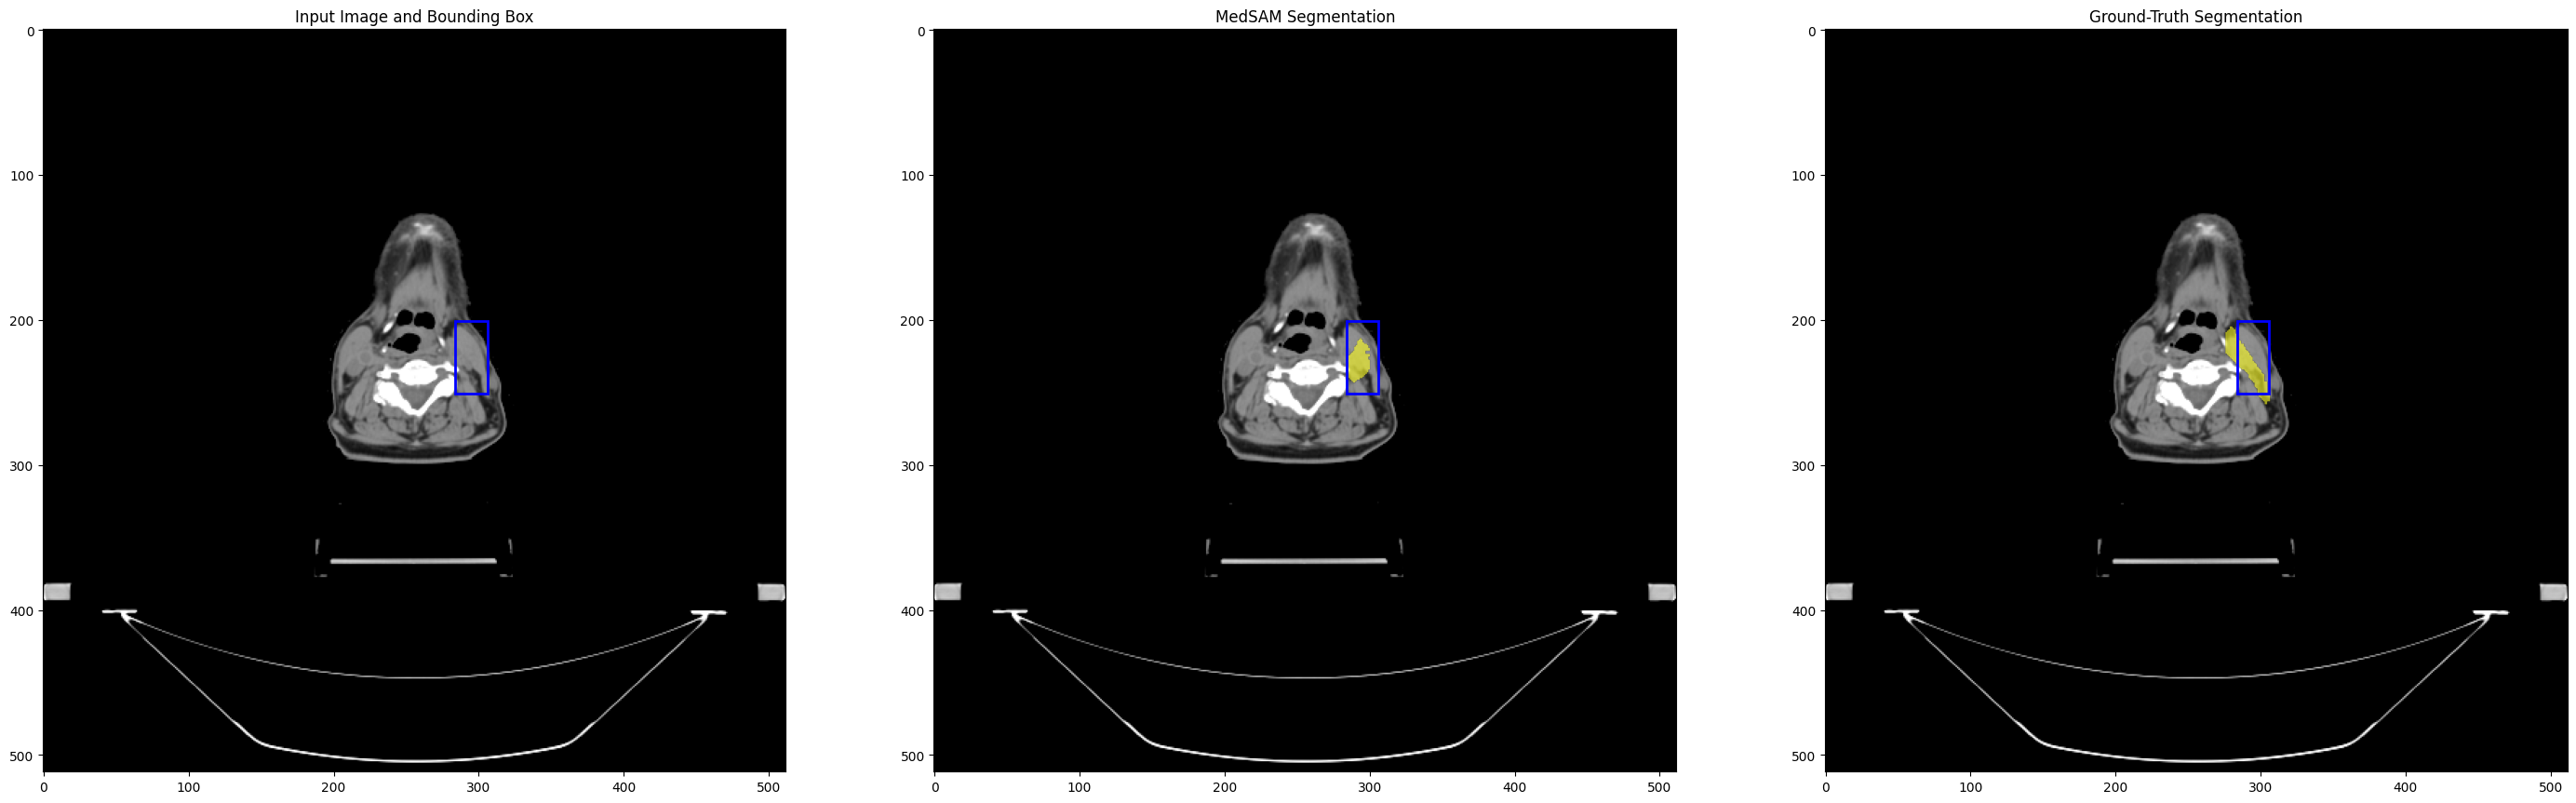

In [180]:
#%% visualize results
fig, ax = plt.subplots(1, 3, figsize=(35, 15))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
ax[2].imshow(img_3c)
show_mask(binmask, ax[2])
show_box(box_np[0], ax[2])
ax[2].set_title("Ground-Truth Segmentation")
plt.show()

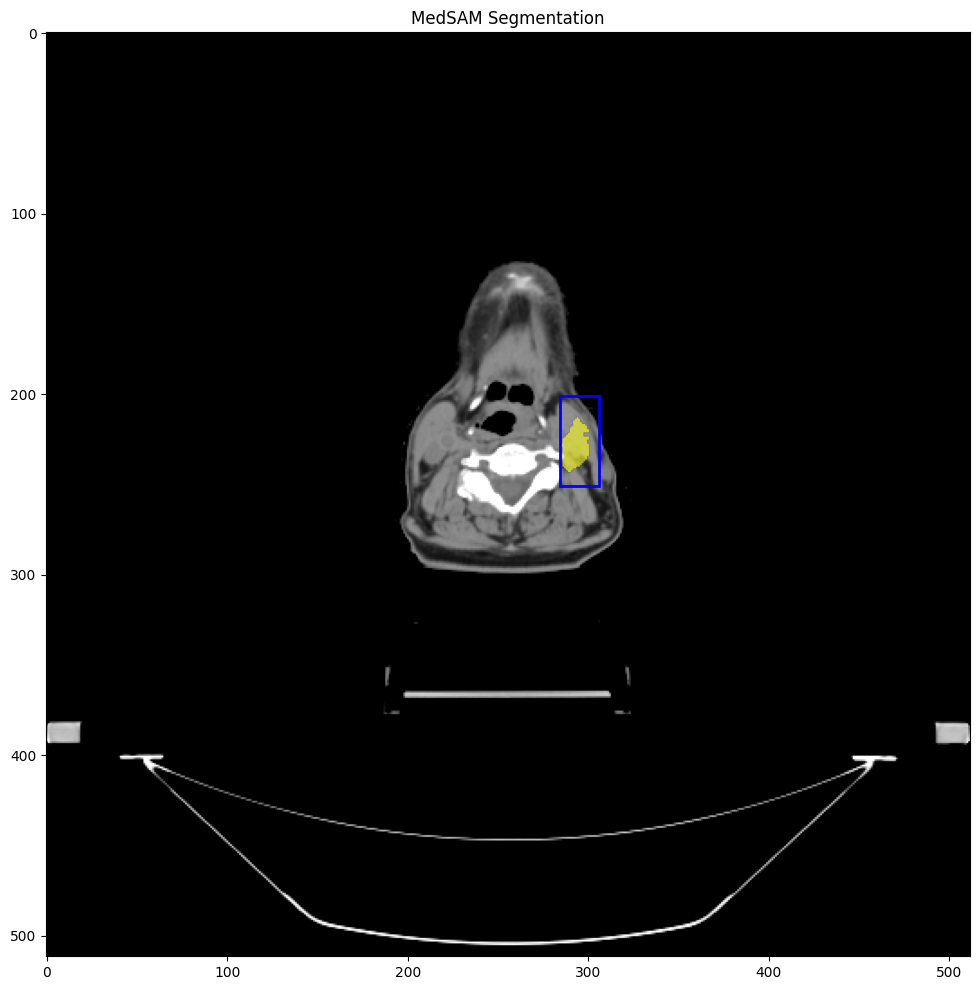

In [181]:
#%% visualize results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(img_3c)
show_mask(medsam_seg, ax)
show_box(box_np[0], ax)
ax.set_title("MedSAM Segmentation")
plt.show()

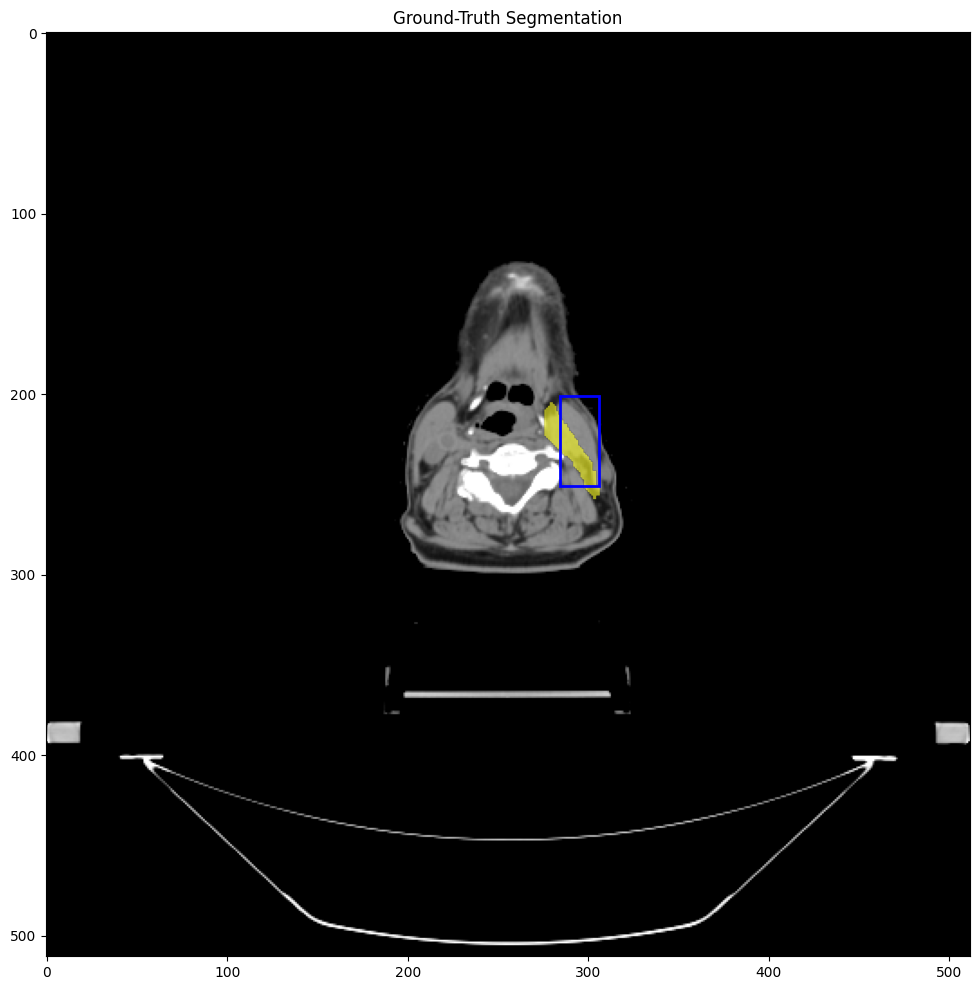

In [182]:
#%% visualize results
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(img_3c)
show_mask(binmask, ax)
show_box(box_np[0], ax)
ax.set_title("Ground-Truth Segmentation")
plt.show()

In [23]:
def shift_box(box, woffset, hoffset):
    return np.array([box[0] - woffset, box[1] - hoffset, box[2] - woffset, box[3] - hoffset])

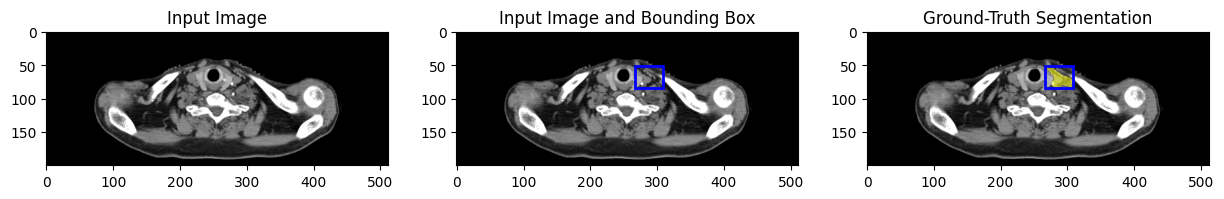

In [31]:
#%% visualize results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(img_3c[150:350,:])
ax[0].set_title("Input Image")
ax[1].imshow(img_3c[150:350,:])
show_box(shift_box(box_np[0],0,150), ax[1])
ax[1].set_title("Input Image and Bounding Box")
ax[2].imshow(img_3c[150:350,:])
show_mask(binmask[150:350,:], ax[2])
show_box(shift_box(box_np[0],0,150), ax[2])
ax[2].set_title("Ground-Truth Segmentation")
plt.show()

### Infer all slices

In [20]:
with torch.no_grad():
    for pat_idx in tqdm(range(len(rpadata))):
        img, mask = rpadata[pat_idx]
        W, H = img.shape[0], img.shape[1]
        pred_mask = np.zeros_like(mask)
        for level, levelnum in levelname2num.items():
            binmask = (mask == levelnum).to(torch.uint8)
            valid_slices = torch.unique(torch.where(binmask > 0)[2])
            for slice_ in valid_slices:
                binmask_slice = binmask[:,:,slice_]
                bbox = get_bbox(binmask_slice.unsqueeze(dim=-1))
                box_np = np.array([[bbox[0][1], bbox[0][0], bbox[1][1], bbox[1][0]]])
                img_3c = np.stack(3*[img[...,slice_]], axis=-1).squeeze()
                img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
                img_1024 = (img_1024 - img_1024.min()) / np.clip(
                    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
                )  # normalize to [0, 1], (H, W, 3)
                # convert the shape to (3, H, W)
                img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0)
                # transfer box_np t0 1024x1024 scale
                box_1024 = box_np / np.array([W, H, W, H]) * 1024
                image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)
                medsam_seg = medsam_bbox_inference(medsam_model, image_embedding, box_1024, H, W)
                pred_mask[:,:,slice_] = levelnum*medsam_seg
        break

  0%|                                                                                                                                                                                                                                                      | 0/46 [09:50<?, ?it/s]


KeyboardInterrupt: 


Slice: 77
Level: level_ii_left
Mask: 0, 1
Pred: False, False



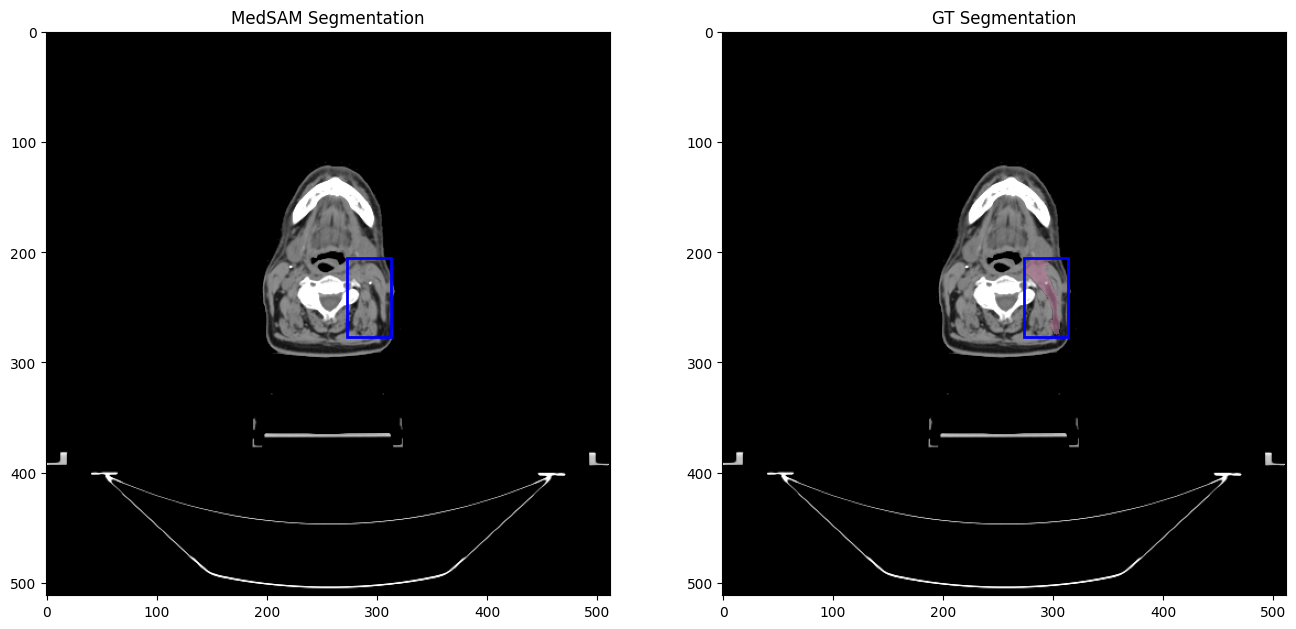

In [43]:
#%% visualize results
img, mask = rpadata[0]
levelnum = 5
binmask = (mask == levelnum).to(torch.uint8)
valid_slices = torch.unique(torch.where(binmask > 0)[2])
slice_ = np.random.choice(valid_slices)
binmask_slice = binmask[:,:,slice_]
img_3c = np.stack(3*[img[...,slice_]], axis=-1).squeeze()
bbox = get_bbox(binmask.unsqueeze(dim=-1))
box_np = np.array([[bbox[0][1], bbox[0][0], bbox[1][1], bbox[1][0]]])
medsam_seg = (pred_mask == levelnum)[:,:,slice_]


print(f"""
Slice: {slice_}
Level: {num2levelname[levelnum]}
Mask: {binmask.min()}, {binmask.max()}
Pred: {medsam_seg.min()}, {medsam_seg.max()}
""")

#%% visualize results
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].set_title("MedSAM Segmentation")
ax[0].imshow(img_3c)
show_mask(medsam_seg, ax[0], random_color=True)
show_box(box_np[0], ax[0])

ax[1].set_title("GT Segmentation")
ax[1].imshow(img_3c)
show_mask(binmask_slice, ax[1], random_color=True)
show_box(box_np[0], ax[1])


plt.show()